In [1]:
# Magics

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
%matplotlib inline

import os, sys, gc
from tqdm import tqdm, tqdm_notebook, tqdm_pandas
from tqdm import trange
import time
from scipy import stats
from scipy.stats import shapiro

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO
from collections import Counter

from multiprocessing import Pool, Process

import itertools
from modules.aa_properties import score_hydrophobicity_sequence, score_positions, score_sequence

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import RandomizedSearchCV

from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

In [54]:
aa =   ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
ignore = ["*", "U", "X"]
viruses = ['CMV_StrainAD169', 'YFV_Strain17D', 'HIV-1_StrainHXB2', 'HCV_StrainIsolateH', 'EBV_StrainAG876']
bacteria = ['SHGLsonnei', 'SLMLenteritidis', 'MYPLpneumoniae', 'MYBTsmegmatis', 'SLMLtyphimurium', 
            'YERSpseudotuberculosis', 'YERSenterocolitica', 'CLMDtrachomatis', 'MYPLsynoviae', 'KLEBpneumoniae',
            'CPBTjejuni', 'SHGLflexneri', 'CLOSdificile']
kidera = ["helix.bend.pref", "side.chain.size",
           "extended.str.pref", "hydrophobicity", "double.bend.pref", "partial.spec.vol",
           "flat.ext.pref", "occurrence.alpha.reg", "pK.C", "surrounding.hydrop"]
fts = ['ft1', 'ft2', 'ft3', 'ft4', 'ft5']

In [5]:
fdict = {}
for key in os.listdir("data/fasta/"):
    if key.startswith("UP0"):
        fdict[key] = "Human"
    else:
        fdict[key] = key.strip("strain.fasta").strip("_")
        
def aa_prot_count(args):
    path, species = args
    record_dict = SeqIO.index("data/fasta/" + path, "fasta")
    df = pd.DataFrame(columns=['species', 'protein']+aa)
    aa_dict  = Counter()
    for key in record_dict.keys():
        aa_dict = aa_dict + Counter(record_dict[key].seq)
        for amino in list(aa_dict):
            if amino in ignore:
                del aa_dict[amino]
        df1 = pd.DataFrame.from_dict(aa_dict, orient='index').T
        df1['species'] = species
        df1['protein'] = key
        df1['prot_len'] = sum(aa_dict.values())
        df = pd.concat([df, df1])
    return df
    
def aa_kidera(args):
    path, species = args
    record_dict = SeqIO.index("data/fasta/" + path, "fasta")
    df = pd.DataFrame(columns=['species', 'protein']+kidera)
    for key in record_dict.keys():
        d = score_sequence(record_dict[key].seq, norm=True)
        df1 = pd.DataFrame(d).T
        df1.columns = kidera
        df1['species'] = species
        df1['protein'] = key
        df = pd.concat([df, df1])
    return df

def aa_hydrophobicity(args):
    path, species = args
    record_dict = SeqIO.index("data/fasta/" + path, "fasta")
    df = pd.DataFrame(columns=['species', 'protein', 'hydrophobicity'])
    for key in record_dict.keys():
        df1 = pd.DataFrame.from_dict({
                'hydrophobicity': score_hydrophobicity_sequence(record_dict[key].seq, norm=True),
                'species': species,
                'protein': key
            }, orient='index').T
        df = pd.concat([df, df1])
    return df

In [ ]:
with Pool(processes=len(fdict)) as pool:
    result = pool.map(aa_prot_count, fdict.items())

pdf = pd.concat(result, axis=0)
pdf = pdf.fillna(0)
pdf = pdf.reset_index(drop=True)

In [10]:
pdf.head()

,A,C,D,E,F,G,H,I,K,L,...,Q,R,S,T,V,W,Y,prot_len,protein,species
0,46,10,27,82,14,24,13,14,40,76,...,64,57,40,18,27,10,13,631.0,sp|Q9H4E7|DEFI6_HUMAN,Human
1,102,18,53,146,18,74,30,27,70,153,...,108,104,90,45,57,14,33,1250.0,sp|Q9NSK0|KLC4_HUMAN,Human
2,128,29,82,183,38,112,47,45,96,208,...,139,146,132,69,86,23,46,1790.0,tr|A0A087X0R7|A0A087X0R7_HUMAN,Human
3,178,43,96,206,72,154,52,83,117,285,...,158,160,181,101,130,39,81,2382.0,sp|Q9NP91|S6A20_HUMAN,Human
4,203,46,118,244,81,183,60,110,150,330,...,174,187,201,114,163,40,88,2788.0,sp|P62195|PRS8_HUMAN,Human


In [11]:
pdf.shape, pdf.drop_duplicates(subset=aa).shape

((70067, 23), (70067, 23))

In [8]:
def count_aa_freq(row):
    return row[aa] / row['prot_len']
df = pdf.apply(lambda row: count_aa_freq(row), axis=1)

In [11]:
df[['protein', 'species']] = pdf[['protein', 'species']]

In [12]:
def group_name(name):
    if name in viruses:
        return 'virus'
    elif name in bacteria:
        return 'bacterium'
    elif name in 'Human':
        return 'human'

def cast_pca(df, n_comp, subset=aa):
    pca = PCA(n_components=n_comp)

    pctd = pca.fit_transform(df[subset])
    pcdf = pd.DataFrame(data = pctd, columns = ['pc' + str(i) for i in range(1,n_comp+1)])
    pcdf['species'] = df.species

    pcdf.species = pcdf.species.apply(lambda x: group_name(x))
    return pcdf, pca

In [13]:
pcdf, pca = cast_pca(df, 10)

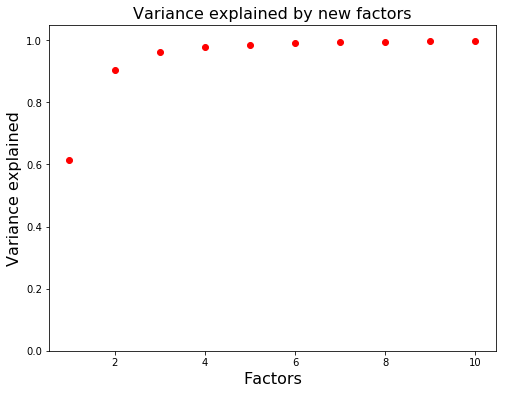

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
evr = pca.explained_variance_ratio_
plt.plot([i for i in range(1, len(evr)+1)], np.cumsum(evr), 'ro')
# padding = 1 + 0.1 *  len(evr)
# ax.set_xlim(1 - padding, len(evr) + padding)
ax.set_title('Variance explained by new factors', fontsize=16)
ax.set_xlabel('Factors', fontsize=16)
ax.set_ylabel('Variance explained', fontsize=16)
ax.set_ylim(0, 1.05);

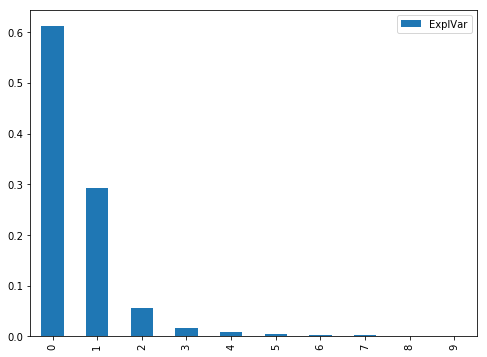

In [29]:
pd.DataFrame(evr, columns=['ExplVar']).plot.bar(figsize=(8,6));

In [30]:
NewAAFactors = pca.components_[:5]
NewAAFactors.shape

(5, 20)

In [33]:
pcdf.columns

Index(['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10',
       'species'],
      dtype='object')

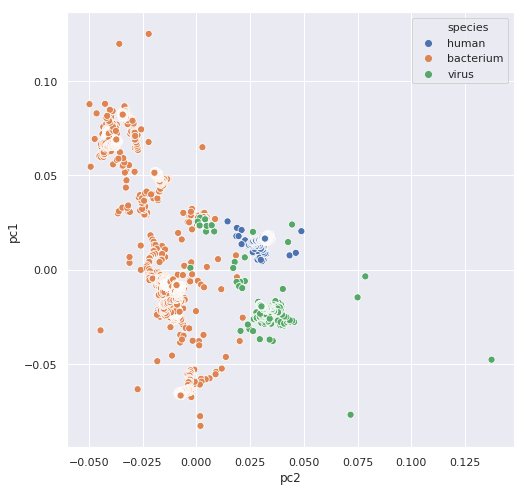

In [43]:
sns.set()
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(ax=ax, x='pc2', y='pc1', hue='species', data=pcdf, s=50);

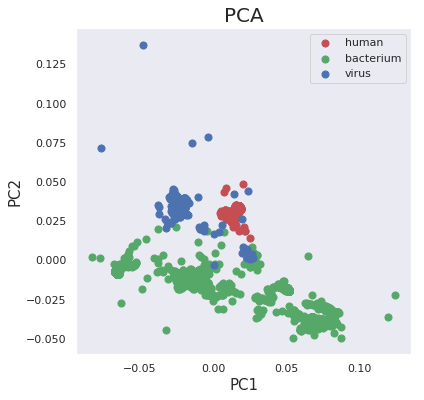

In [44]:
def plot_pca(pcdf):
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('PC1', fontsize = 15)
    ax.set_ylabel('PC2', fontsize = 15)
    ax.set_title('PCA', fontsize = 20)

    targets = pcdf.species.unique()
    colours = ['r', 'g', 'b']
    for target, colour in zip(targets,colours):
        indicesToKeep = pcdf['species'] == target
        ax.scatter(pcdf.loc[indicesToKeep, 'pc1']
                   , pcdf.loc[indicesToKeep, 'pc2']
                   , c = colour
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    
plot_pca(pcdf)

## Train Classifier

In [45]:
fdf = df[~df['species'].isin(['SLMLenteritidis', 'EBV_StrainAG876'])]
fdf.shape

(65660, 22)

In [46]:
fdf.species = fdf.species.apply(lambda x: group_name(x))
di = {'virus': 0, 'bacterium': 0, 'human': 1}
fdf.replace({'species': di}, inplace=True)
fdf[['species', 'protein']].head()

,species,protein
0,1,sp|Q9H4E7|DEFI6_HUMAN
1,1,sp|Q9NSK0|KLC4_HUMAN
2,1,tr|A0A087X0R7|A0A087X0R7_HUMAN
3,1,sp|Q9NP91|S6A20_HUMAN
4,1,sp|P62195|PRS8_HUMAN


In [47]:
clf = SVC()

X_train, X_test, y_train, y_test = train_test_split(pca.transform(fdf[aa]), 
                                                    fdf['species'].values, 
                                                    test_size=.25)

scores = cross_val_score(clf, X=X_train, y=y_train, cv=5)
np.mean(scores)

0.99681186316878367

In [48]:
clf.fit(X=X_train, y=y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [49]:
test_df = df[df['species'].isin(['SLMLenteritidis', 'EBV_StrainAG876', 'Human'])]
test_df['species'] = test_df.species.apply(lambda x: group_name(x))
test_df.replace({'species': di}, inplace=True)
X_ultratest = pca.transform(test_df[aa])
y_ultratest = test_df.species

In [50]:
print(classification_report(y_test, clf.predict(X_test), labels=[0, 1]))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     11169
          1       0.99      1.00      1.00      5246

avg / total       1.00      1.00      1.00     16415



In [51]:
print(classification_report(y_ultratest, clf.predict(X_ultratest), labels=[0, 1]))

             precision    recall  f1-score   support

          0       1.00      0.98      0.99      4407
          1       1.00      1.00      1.00     21033

avg / total       1.00      1.00      1.00     25440



## New Factors and Kidera factors correlation

In [52]:
kid = pd.read_csv('modules/kidera.csv', header=None, names=kidera)
from modules.aa_properties import symbol_lookup
kid.index = kid.index.map(lambda x: symbol_lookup[x])
# kid

In [59]:
factors.columns = fts
fact_df = pd.concat([kid, factors], axis=1)

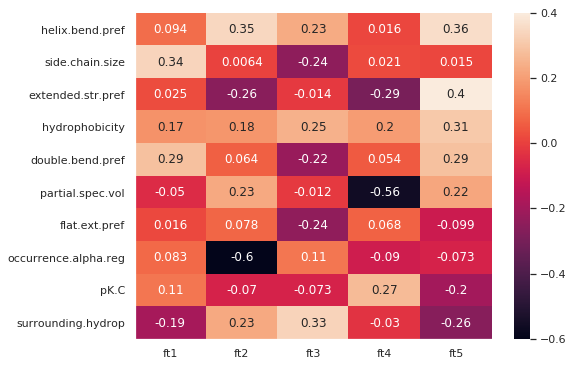

In [63]:
sns.set()
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(fact_df.corr().loc[fts, kidera].T, annot=True, fmt='.2g')
sns.despine(ax=ax);

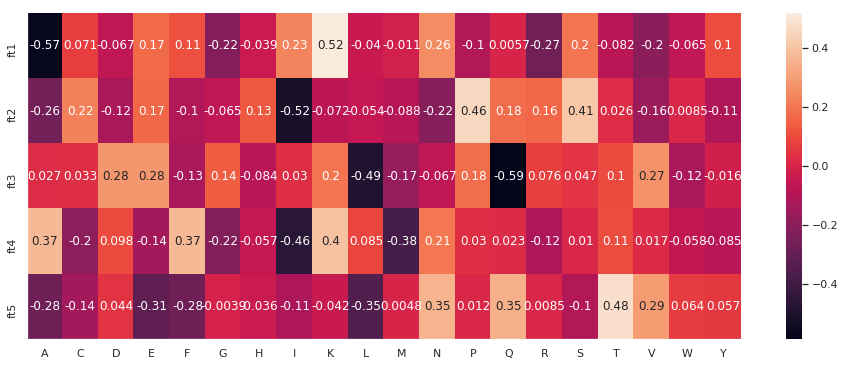

In [64]:
sns.set()
fig, ax = plt.subplots(figsize=(16,6))
sns.heatmap(factors.T, annot=True, fmt='.2g')
sns.despine(ax=ax);

## Let's take a look at immunogenic peptides

In [56]:
cdf = pd.read_csv('data/chowell.csv')
cdf = cdf[['peptide', 'Immunogenicity']]
cdf.head()

,peptide,Immunogenicity
0,KLEDLERDL,Positive
1,DLMGYIPLV,Positive
2,QTVTSTPVQGR,Positive
3,TTVYPPSSTAK,Positive
4,LITGRLQSL,Positive


In [57]:
cdf.Immunogenicity = cdf.Immunogenicity.map({'Positive':1,'Negative':0})

In [58]:
factors = pd.DataFrame(NewAAFactors, columns=aa).T
factors.shape

(20, 5)

In [65]:
def score_factors(sequence, norm=False):
    if norm:
        return factors.loc[list(sequence)].sum() / len(sequence)
    else:
        return factors.loc[list(sequence)].sum()
    
ndf = pd.concat([cdf, cdf.peptide.apply(lambda s: score_factors(s))], axis=1)
ndf.head()

,peptide,Immunogenicity,ft1,ft2,ft3,ft4,ft5
0,KLEDLERDL,1,0.338626,0.016178,-0.067392,0.461681,-1.636893
1,DLMGYIPLV,1,-0.346006,-0.710233,-0.265690,-0.837055,-0.415742
2,QTVTSTPVQGR,1,-1.037330,1.083325,0.101139,0.099750,2.639213
3,TTVYPPSSTAK,1,-0.211952,1.213853,1.228986,1.097829,1.296468
4,LITGRLQSL,1,-0.257006,0.035621,-1.660607,-0.406249,-0.447681


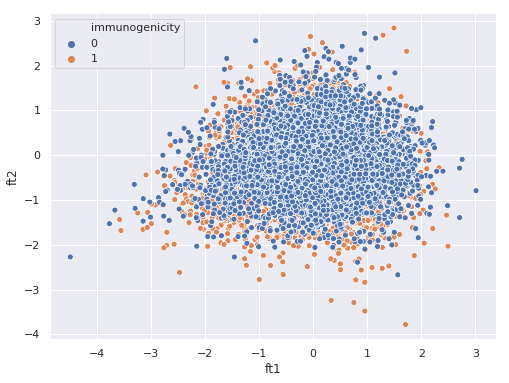

In [67]:
ndf.columns = ['peptide', 'immunogenicity'] + fts
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x="ft1", y="ft2", hue='immunogenicity', data=ndf);

In [68]:
ndf.columns = ['peptide', 'immunogenicity'] + fts

X_train, X_test, y_train, y_test = train_test_split(ndf[fts].values, ndf.immunogenicity, test_size=.25)
clf = RandomForestClassifier(n_estimators=400)

scores = cross_val_score(clf, X=X_train, y=y_train, cv=5)
np.mean(scores)

0.60571553981966331

In [69]:
scores

array([ 0.61927224,  0.59743763,  0.60215779,  0.5954147 ,  0.61429535])

In [70]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = clf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=0, random_state=42, n_jobs = -1)

In [71]:
rf_random.fit(X_train, y_train);

In [72]:
rf_random.best_score_

0.6178532901833873

## New factors and Kidera facors combined

In [73]:
adf = pd.concat([
        cdf,
        cdf.peptide.apply(lambda s: score_factors(s)),
        cdf.peptide.apply(lambda s: score_sequence(s))
    ], axis=1)

adf.columns = ['peptide', 'Immunogenicity'] + fts + kidera
adf.head()

,peptide,Immunogenicity,ft1,ft2,ft3,ft4,ft5,helix.bend.pref,side.chain.size,extended.str.pref,hydrophobicity,double.bend.pref,partial.spec.vol,flat.ext.pref,occurrence.alpha.reg,pK.C,surrounding.hydrop
0,KLEDLERDL,1,0.338626,0.016178,-0.067392,0.461681,-1.636893,-4.98,2.03,-5.96,4.23,-6.27,-6.21,1.99,-1.05,1.92,5.48
1,DLMGYIPLV,1,-0.346006,-0.710233,-0.265690,-0.837055,-0.415742,0.53,-1.72,0.77,-4.76,0.92,-4.45,0.07,0.72,-0.38,2.41
2,QTVTSTPVQGR,1,-1.037330,1.083325,0.101139,0.099750,2.639213,2.91,-5.14,8.00,4.67,1.97,-0.34,0.91,-6.23,-4.32,-1.91
3,TTVYPPSSTAK,1,-0.211952,1.213853,1.228986,1.097829,1.296468,5.26,-5.00,3.29,1.70,2.15,-5.02,-2.89,-9.42,-2.92,0.85
4,LITGRLQSL,1,-0.257006,0.035621,-1.660607,-0.406249,-0.447681,-1.57,-2.39,3.65,-0.21,-3.00,-5.40,3.48,-2.81,-0.98,0.03


In [168]:
X_train, X_test, y_train, y_test = train_test_split(adf[fts+kidera].values, adf.Immunogenicity, test_size=.25)
clf = RandomForestClassifier(n_estimators=400)

scores = cross_val_score(clf, X=X_train, y=y_train, cv=5)
np.mean(scores)

0.71885042557744294

In [169]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = clf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=0, random_state=42, n_jobs = -1)

In [170]:
rf_random.fit(X_train, y_train);

In [171]:
rf_random.best_score_

0.71992988133764835

## Kidera alone

In [172]:
X_train, X_test, y_train, y_test = train_test_split(adf[kidera].values, adf.Immunogenicity, test_size=.25)
clf = RandomForestClassifier(n_estimators=400)

scores = cross_val_score(clf, X=X_train, y=y_train, cv=5)
np.mean(scores)

0.70792361629214384

In [173]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = clf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=0, random_state=42, n_jobs = -1)

In [174]:
rf_random.fit(X_train, y_train);

In [175]:
rf_random.best_score_

0.71049083063646168

## With SVM self score

In [188]:
def aa_new_factors(args):
    path, species = args
    record_dict = SeqIO.index("data/fasta/" + path, "fasta")
    df = pd.DataFrame(columns=['species', 'peptide'])
    for key in record_dict.keys():
        seq = record_dict[key]
        d = pd.Series([seq[i:i+9] for i in range(len(seq)-8)])
        df1 = pd.DataFrame(d, columns=['peptide'])
        df1['species'] = species
        df = pd.concat([df, df1])
    fdf = pd.concat([
            df,
            df.peptide.apply(lambda s: score_factors(s))
        ], axis=1)
    return fdf

In [ ]:
with Pool(processes=len(fdict)) as pool:
    result = pool.map(aa_new_factors, fdict.items())

fdf = pd.concat(result, axis=0)
fdf = fdf.reset_index(drop=True)

In [ ]:
fdf.head()